# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
from sklearn.metrics import classification_report

from dataset_utils import Cinc2017DataModule
from model import DenseNetGruEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")
dst_length = dst_freq * dst_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Model


In [4]:
model = DenseNetGruEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr=1e-3,
    min_lr = 1e-5,
    show_valid_cm=True,
    growth_rate=16,
    block_config=(4, 4, 12, 8, 8, 8),
    num_init_features=64,
    bn_size=4,
    db_drop_rate=0.2,
    gru_drop_rate=0.2,
    fc_drop_rate=0.5,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (32 + 6 * 16) // 2 = 64
# (64 + 4 * 16) // 2 = 64
# (64 + 12 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (256 + 8 * 16) // 2 = 128

## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auroc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model


In [6]:
trainer.fit(model, datamodule=dm)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetGruEcg            | 1.3 M  | train | [1, 1, 6000] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
1.3 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:17<00:00,  5.19it/s, v_num=y6yj, lr=0.001, valid_loss=1.060, valid_acc=0.439, valid_auroc=0.529, valid_f1=0.333, train_loss=1.100, train_acc=0.342, train_auroc=0.512, train_f1=0.340]

Epoch 0, global step 91: 'valid_auroc' reached 0.52917 (best 0.52917), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[441, 173, 148],
        [ 56,  34,  24],
        [205,  88,  69]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:17<00:00,  5.18it/s, v_num=y6yj, lr=0.001, valid_loss=0.987, valid_acc=0.539, valid_auroc=0.766, valid_f1=0.445, train_loss=1.030, train_acc=0.451, train_auroc=0.632, train_f1=0.437]

Epoch 1, global step 182: 'valid_auroc' reached 0.76596 (best 0.76596), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=1-step=182.ckpt' as top 1



Valid Confusion Matrix:
tensor([[502, 129, 131],
        [ 12,  86,  16],
        [ 98, 185,  79]], device='cuda:0')
Epoch 2: 100%|██████████| 91/91 [00:17<00:00,  5.17it/s, v_num=y6yj, lr=0.001, valid_loss=0.717, valid_acc=0.674, valid_auroc=0.838, valid_f1=0.591, train_loss=0.861, train_acc=0.585, train_auroc=0.761, train_f1=0.572]

Epoch 2, global step 273: 'valid_auroc' reached 0.83802 (best 0.83802), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=2-step=273.ckpt' as top 1



Valid Confusion Matrix:
tensor([[599,  37, 126],
        [  4,  96,  14],
        [ 99, 123, 140]], device='cuda:0')
Epoch 3: 100%|██████████| 91/91 [00:17<00:00,  5.16it/s, v_num=y6yj, lr=0.001, valid_loss=0.577, valid_acc=0.755, valid_auroc=0.870, valid_f1=0.676, train_loss=0.734, train_acc=0.676, train_auroc=0.830, train_f1=0.672]

Epoch 3, global step 364: 'valid_auroc' reached 0.87022 (best 0.87022), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=3-step=364.ckpt' as top 1



Valid Confusion Matrix:
tensor([[701,  10,  51],
        [  8,  96,  10],
        [160,  64, 138]], device='cuda:0')
Epoch 4: 100%|██████████| 91/91 [00:17<00:00,  5.14it/s, v_num=y6yj, lr=0.001, valid_loss=0.544, valid_acc=0.780, valid_auroc=0.899, valid_f1=0.725, train_loss=0.629, train_acc=0.728, train_auroc=0.875, train_f1=0.722]

Epoch 4, global step 455: 'valid_auroc' reached 0.89927 (best 0.89927), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=4-step=455.ckpt' as top 1



Valid Confusion Matrix:
tensor([[647,  16,  99],
        [  3, 101,  10],
        [ 75,  69, 218]], device='cuda:0')
Epoch 5: 100%|██████████| 91/91 [00:17<00:00,  5.13it/s, v_num=y6yj, lr=0.001, valid_loss=0.450, valid_acc=0.821, valid_auroc=0.919, valid_f1=0.778, train_loss=0.569, train_acc=0.764, train_auroc=0.898, train_f1=0.758]

Epoch 5, global step 546: 'valid_auroc' reached 0.91937 (best 0.91937), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=5-step=546.ckpt' as top 1



Valid Confusion Matrix:
tensor([[684,   4,  74],
        [  3,  86,  25],
        [ 89,  26, 247]], device='cuda:0')
Epoch 6: 100%|██████████| 91/91 [00:17<00:00,  5.14it/s, v_num=y6yj, lr=0.001, valid_loss=0.550, valid_acc=0.783, valid_auroc=0.885, valid_f1=0.709, train_loss=0.524, train_acc=0.786, train_auroc=0.915, train_f1=0.784]

Epoch 6, global step 637: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[688,   7,  67],
        [  6,  69,  39],
        [121,  29, 212]], device='cuda:0')
Epoch 7: 100%|██████████| 91/91 [00:17<00:00,  5.13it/s, v_num=y6yj, lr=0.001, valid_loss=0.528, valid_acc=0.792, valid_auroc=0.911, valid_f1=0.743, train_loss=0.485, train_acc=0.802, train_auroc=0.927, train_f1=0.801]

Epoch 7, global step 728: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[643,  21,  98],
        [  1, 110,   3],
        [ 62,  72, 228]], device='cuda:0')
Epoch 8: 100%|██████████| 91/91 [00:17<00:00,  5.12it/s, v_num=y6yj, lr=0.001, valid_loss=0.422, valid_acc=0.831, valid_auroc=0.934, valid_f1=0.780, train_loss=0.458, train_acc=0.815, train_auroc=0.935, train_f1=0.814]

Epoch 8, global step 819: 'valid_auroc' reached 0.93423 (best 0.93423), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=8-step=819.ckpt' as top 1



Valid Confusion Matrix:
tensor([[689,  20,  53],
        [  0, 106,   8],
        [ 76,  52, 234]], device='cuda:0')
Epoch 9: 100%|██████████| 91/91 [00:17<00:00,  5.11it/s, v_num=y6yj, lr=0.001, valid_loss=0.448, valid_acc=0.831, valid_auroc=0.931, valid_f1=0.788, train_loss=0.424, train_acc=0.831, train_auroc=0.943, train_f1=0.828]

Epoch 9, global step 910: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[679,  19,  64],
        [  0, 100,  14],
        [ 76,  36, 250]], device='cuda:0')
Epoch 10: 100%|██████████| 91/91 [00:17<00:00,  5.11it/s, v_num=y6yj, lr=0.001, valid_loss=0.409, valid_acc=0.852, valid_auroc=0.942, valid_f1=0.826, train_loss=0.409, train_acc=0.840, train_auroc=0.947, train_f1=0.839]

Epoch 10, global step 1001: 'valid_auroc' reached 0.94159 (best 0.94159), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=10-step=1001.ckpt' as top 1



Valid Confusion Matrix:
tensor([[684,   8,  70],
        [  0, 103,  11],
        [ 68,  26, 268]], device='cuda:0')
Epoch 11: 100%|██████████| 91/91 [00:17<00:00,  5.11it/s, v_num=y6yj, lr=0.001, valid_loss=0.395, valid_acc=0.848, valid_auroc=0.940, valid_f1=0.817, train_loss=0.397, train_acc=0.841, train_auroc=0.950, train_f1=0.840]

Epoch 11, global step 1092: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   3,  61],
        [  3,  94,  17],
        [ 82,  22, 258]], device='cuda:0')
Epoch 12: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.001, valid_loss=0.450, valid_acc=0.824, valid_auroc=0.930, valid_f1=0.791, train_loss=0.401, train_acc=0.842, train_auroc=0.947, train_f1=0.840]

Epoch 12, global step 1183: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[671,  17,  74],
        [  2, 108,   4],
        [ 84,  37, 241]], device='cuda:0')
Epoch 13: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=y6yj, lr=0.001, valid_loss=0.507, valid_acc=0.819, valid_auroc=0.928, valid_f1=0.783, train_loss=0.378, train_acc=0.851, train_auroc=0.953, train_f1=0.848]

Epoch 13, global step 1274: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[644,  22,  96],
        [  0, 111,   3],
        [ 53,  50, 259]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:17<00:00,  5.10it/s, v_num=y6yj, lr=0.001, valid_loss=0.439, valid_acc=0.815, valid_auroc=0.932, valid_f1=0.779, train_loss=0.377, train_acc=0.849, train_auroc=0.952, train_f1=0.848]

Epoch 14, global step 1365: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[669,  15,  78],
        [  0, 106,   8],
        [ 87,  41, 234]], device='cuda:0')
Epoch 15: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=y6yj, lr=0.001, valid_loss=0.505, valid_acc=0.817, valid_auroc=0.927, valid_f1=0.777, train_loss=0.361, train_acc=0.859, train_auroc=0.955, train_f1=0.857]

Epoch 15, global step 1456: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[658,  23,  81],
        [  0, 105,   9],
        [ 70,  43, 249]], device='cuda:0')
Epoch 16: 100%|██████████| 91/91 [00:17<00:00,  5.09it/s, v_num=y6yj, lr=0.001, valid_loss=0.443, valid_acc=0.828, valid_auroc=0.935, valid_f1=0.789, train_loss=0.369, train_acc=0.855, train_auroc=0.955, train_f1=0.854]

Epoch 16, global step 1547: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[661,  18,  83],
        [  0, 111,   3],
        [ 57,  52, 253]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.414, valid_acc=0.847, valid_auroc=0.937, valid_f1=0.812, train_loss=0.325, train_acc=0.879, train_auroc=0.963, train_f1=0.877]

Epoch 17, global step 1638: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[712,   4,  46],
        [  1,  99,  14],
        [ 96,  28, 238]], device='cuda:0')
Epoch 18: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.401, valid_acc=0.855, valid_auroc=0.940, valid_f1=0.821, train_loss=0.331, train_acc=0.870, train_auroc=0.963, train_f1=0.868]

Epoch 18, global step 1729: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[697,  12,  53],
        [  1, 107,   6],
        [ 74,  34, 254]], device='cuda:0')
Epoch 19: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.431, valid_acc=0.842, valid_auroc=0.937, valid_f1=0.802, train_loss=0.312, train_acc=0.879, train_auroc=0.966, train_f1=0.878]
Valid Confusion Matrix:
tensor([[708,   3,  51],
        [  2,  82,  30],
        [ 99,  11, 252]], device='cuda:0')


Epoch 19, global step 1820: 'valid_auroc' was not in top 1


Epoch 20: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.420, valid_acc=0.854, valid_auroc=0.940, valid_f1=0.827, train_loss=0.329, train_acc=0.875, train_auroc=0.963, train_f1=0.874]
Valid Confusion Matrix:
tensor([[673,  10,  79],
        [  0, 107,   7],
        [ 52,  33, 277]], device='cuda:0')


Epoch 20, global step 1911: 'valid_auroc' was not in top 1


Epoch 21: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.422, valid_acc=0.860, valid_auroc=0.939, valid_f1=0.830, train_loss=0.294, train_acc=0.887, train_auroc=0.970, train_f1=0.886]

Epoch 21, global step 2002: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[690,  10,  62],
        [  0, 108,   6],
        [ 61,  34, 267]], device='cuda:0')
Epoch 22: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.424, valid_acc=0.845, valid_auroc=0.936, valid_f1=0.816, train_loss=0.325, train_acc=0.875, train_auroc=0.964, train_f1=0.875]

Epoch 22, global step 2093: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   7,  57],
        [  2,  98,  14],
        [ 91,  21, 250]], device='cuda:0')
Epoch 23: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.425, valid_acc=0.862, valid_auroc=0.947, valid_f1=0.828, train_loss=0.300, train_acc=0.891, train_auroc=0.968, train_f1=0.891]

Epoch 23, global step 2184: 'valid_auroc' reached 0.94679 (best 0.94679), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=23-step=2184.ckpt' as top 1



Valid Confusion Matrix:
tensor([[731,   6,  25],
        [  1, 100,  13],
        [104,  22, 236]], device='cuda:0')
Epoch 24: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.001, valid_loss=0.416, valid_acc=0.856, valid_auroc=0.944, valid_f1=0.822, train_loss=0.296, train_acc=0.894, train_auroc=0.970, train_f1=0.894]

Epoch 24, global step 2275: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[700,   4,  58],
        [  1,  91,  22],
        [ 74,  19, 269]], device='cuda:0')
Epoch 25: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.397, valid_acc=0.870, valid_auroc=0.946, valid_f1=0.843, train_loss=0.257, train_acc=0.905, train_auroc=0.976, train_f1=0.904]

Epoch 25, global step 2366: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[699,   4,  59],
        [  1, 105,   8],
        [ 60,  29, 273]], device='cuda:0')
Epoch 26: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.465, valid_acc=0.838, valid_auroc=0.942, valid_f1=0.820, train_loss=0.240, train_acc=0.908, train_auroc=0.978, train_f1=0.907]

Epoch 26, global step 2457: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[635,  10, 117],
        [  0, 104,  10],
        [ 36,  27, 299]], device='cuda:0')
Epoch 27: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.472, valid_acc=0.843, valid_auroc=0.937, valid_f1=0.820, train_loss=0.246, train_acc=0.907, train_auroc=0.978, train_f1=0.907]

Epoch 27, global step 2548: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[654,  11,  97],
        [  0, 105,   9],
        [ 48,  29, 285]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.431, valid_acc=0.875, valid_auroc=0.942, valid_f1=0.848, train_loss=0.226, train_acc=0.913, train_auroc=0.981, train_f1=0.912]

Epoch 28, global step 2639: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[703,   7,  52],
        [  1, 103,  10],
        [ 62,  23, 277]], device='cuda:0')
Epoch 29: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.419, valid_acc=0.859, valid_auroc=0.946, valid_f1=0.837, train_loss=0.232, train_acc=0.910, train_auroc=0.980, train_f1=0.911]
Valid Confusion Matrix:
tensor([[671,   6,  85],
        [  0, 105,   9],
        [ 48,  27, 287]], device='cuda:0')


Epoch 29, global step 2730: 'valid_auroc' was not in top 1


Epoch 30: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.425, valid_acc=0.857, valid_auroc=0.946, valid_f1=0.833, train_loss=0.216, train_acc=0.919, train_auroc=0.983, train_f1=0.919]

Epoch 30, global step 2821: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[678,   8,  76],
        [  1, 102,  11],
        [ 57,  24, 281]], device='cuda:0')
Epoch 31: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.408, valid_acc=0.872, valid_auroc=0.948, valid_f1=0.844, train_loss=0.213, train_acc=0.921, train_auroc=0.983, train_f1=0.921]

Epoch 31, global step 2912: 'valid_auroc' reached 0.94786 (best 0.94786), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=31-step=2912.ckpt' as top 1



Valid Confusion Matrix:
tensor([[690,   5,  67],
        [  1, 101,  12],
        [ 48,  26, 288]], device='cuda:0')
Epoch 32: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.0005, valid_loss=0.497, valid_acc=0.841, valid_auroc=0.937, valid_f1=0.814, train_loss=0.219, train_acc=0.919, train_auroc=0.982, train_f1=0.919]

Epoch 32, global step 3003: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[655,  10,  97],
        [  1, 103,  10],
        [ 47,  32, 283]], device='cuda:0')
Epoch 33: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.460, valid_acc=0.863, valid_auroc=0.944, valid_f1=0.840, train_loss=0.211, train_acc=0.920, train_auroc=0.982, train_f1=0.920]

Epoch 33, global step 3094: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[679,   5,  78],
        [  0, 102,  12],
        [ 49,  25, 288]], device='cuda:0')
Epoch 34: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.433, valid_acc=0.872, valid_auroc=0.946, valid_f1=0.847, train_loss=0.203, train_acc=0.921, train_auroc=0.985, train_f1=0.920]

Epoch 34, global step 3185: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[692,   5,  65],
        [  1, 100,  13],
        [ 53,  21, 288]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.475, valid_acc=0.863, valid_auroc=0.944, valid_f1=0.842, train_loss=0.193, train_acc=0.930, train_auroc=0.986, train_f1=0.930]

Epoch 35, global step 3276: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[669,   7,  86],
        [  0, 105,   9],
        [ 42,  26, 294]], device='cuda:0')
Epoch 36: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.0005, valid_loss=0.422, valid_acc=0.869, valid_auroc=0.948, valid_f1=0.841, train_loss=0.194, train_acc=0.927, train_auroc=0.986, train_f1=0.927]

Epoch 36, global step 3367: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[688,   9,  65],
        [  0, 102,  12],
        [ 51,  25, 286]], device='cuda:0')
Epoch 37: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.00025, valid_loss=0.428, valid_acc=0.868, valid_auroc=0.947, valid_f1=0.842, train_loss=0.182, train_acc=0.929, train_auroc=0.988, train_f1=0.928]

Epoch 37, global step 3458: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[688,   7,  67],
        [  1, 102,  11],
        [ 54,  24, 284]], device='cuda:0')
Epoch 38: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.00025, valid_loss=0.462, valid_acc=0.862, valid_auroc=0.946, valid_f1=0.838, train_loss=0.181, train_acc=0.935, train_auroc=0.987, train_f1=0.935]

Epoch 38, global step 3549: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[673,   9,  80],
        [  0, 103,  11],
        [ 47,  24, 291]], device='cuda:0')
Epoch 39: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.00025, valid_loss=0.428, valid_acc=0.882, valid_auroc=0.948, valid_f1=0.860, train_loss=0.178, train_acc=0.933, train_auroc=0.988, train_f1=0.934]

Epoch 39, global step 3640: 'valid_auroc' reached 0.94810 (best 0.94810), saving model to 'wandb_logs/awin-ecg-centralized/lwtoy6yj/checkpoints/epoch=39-step=3640.ckpt' as top 1



Valid Confusion Matrix:
tensor([[691,   6,  65],
        [  0, 106,   8],
        [ 43,  24, 295]], device='cuda:0')
Epoch 40: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.417, valid_acc=0.874, valid_auroc=0.948, valid_f1=0.849, train_loss=0.188, train_acc=0.931, train_auroc=0.987, train_f1=0.932]

Epoch 40, global step 3731: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[689,   7,  66],
        [  0, 102,  12],
        [ 49,  22, 291]], device='cuda:0')
Epoch 41: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.441, valid_acc=0.875, valid_auroc=0.948, valid_f1=0.848, train_loss=0.162, train_acc=0.941, train_auroc=0.990, train_f1=0.941]

Epoch 41, global step 3822: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[695,   3,  64],
        [  1,  95,  18],
        [ 52,  17, 293]], device='cuda:0')
Epoch 42: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.465, valid_acc=0.872, valid_auroc=0.944, valid_f1=0.847, train_loss=0.175, train_acc=0.937, train_auroc=0.988, train_f1=0.936]

Epoch 42, global step 3913: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[690,   6,  66],
        [  1, 101,  12],
        [ 51,  22, 289]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.458, valid_acc=0.876, valid_auroc=0.946, valid_f1=0.852, train_loss=0.155, train_acc=0.941, train_auroc=0.990, train_f1=0.941]
Valid Confusion Matrix:
tensor([[683,   8,  71],
        [  0, 104,  10],
        [ 42,  23, 297]], device='cuda:0')


Epoch 43, global step 4004: 'valid_auroc' was not in top 1


Epoch 44: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.00025, valid_loss=0.435, valid_acc=0.880, valid_auroc=0.946, valid_f1=0.855, train_loss=0.163, train_acc=0.938, train_auroc=0.990, train_f1=0.937]

Epoch 44, global step 4095: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   6,  58],
        [  0, 102,  12],
        [ 50,  22, 290]], device='cuda:0')
Epoch 45: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.00025, valid_loss=0.467, valid_acc=0.868, valid_auroc=0.944, valid_f1=0.841, train_loss=0.146, train_acc=0.944, train_auroc=0.992, train_f1=0.944]

Epoch 45, global step 4186: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[690,   6,  66],
        [  1,  99,  14],
        [ 56,  21, 285]], device='cuda:0')
Epoch 46: 100%|██████████| 91/91 [00:17<00:00,  5.08it/s, v_num=y6yj, lr=0.00025, valid_loss=0.473, valid_acc=0.872, valid_auroc=0.944, valid_f1=0.847, train_loss=0.161, train_acc=0.940, train_auroc=0.990, train_f1=0.939]

Epoch 46, global step 4277: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[690,   7,  65],
        [  0, 105,   9],
        [ 53,  25, 284]], device='cuda:0')
Epoch 47: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.511, valid_acc=0.870, valid_auroc=0.940, valid_f1=0.852, train_loss=0.163, train_acc=0.938, train_auroc=0.989, train_f1=0.938]

Epoch 47, global step 4368: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[678,   7,  77],
        [  0, 107,   7],
        [ 47,  23, 292]], device='cuda:0')
Epoch 48: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.456, valid_acc=0.874, valid_auroc=0.947, valid_f1=0.849, train_loss=0.158, train_acc=0.942, train_auroc=0.990, train_f1=0.943]

Epoch 48, global step 4459: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[694,   4,  64],
        [  1,  99,  14],
        [ 53,  20, 289]], device='cuda:0')
Epoch 49: 100%|██████████| 91/91 [00:17<00:00,  5.07it/s, v_num=y6yj, lr=0.00025, valid_loss=0.477, valid_acc=0.863, valid_auroc=0.946, valid_f1=0.840, train_loss=0.147, train_acc=0.944, train_auroc=0.992, train_f1=0.944]

Epoch 49, global step 4550: 'valid_auroc' was not in top 1



Valid Confusion Matrix:
tensor([[676,   4,  82],
        [  0,  97,  17],
        [ 48,  19, 295]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate the Model on the Test Set


In [7]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    accuracy_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import multiclass_auroc
import torch

def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)
    
    return loss, y_pred, y, y_hat

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 20.70it/s]
test_loss: 0.5083109736442566
test_auroc: 0.9366245269775391
              precision    recall  f1-score   support

           N       0.91      0.88      0.89       762
           A       0.83      0.79      0.81       114
           O       0.72      0.78      0.75       362

    accuracy                           0.84      1238
   macro avg       0.82      0.82      0.82      1238
weighted avg       0.85      0.84      0.84      1238



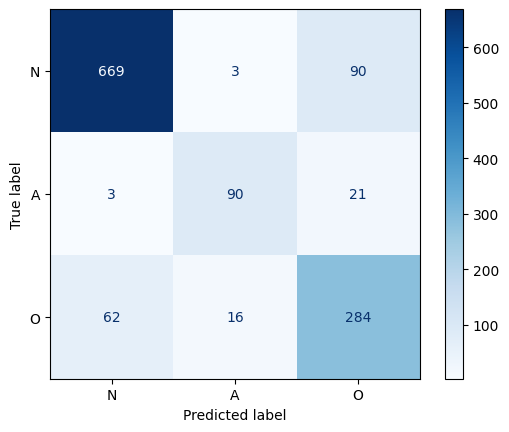

In [8]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# # auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 20.75it/s]
test_loss: 0.45205241441726685
test_auroc: 0.9376425743103027
              precision    recall  f1-score   support

           N       0.92      0.89      0.90       762
           A       0.79      0.87      0.83       114
           O       0.75      0.78      0.76       362

    accuracy                           0.86      1238
   macro avg       0.82      0.85      0.83      1238
weighted avg       0.86      0.86      0.86      1238



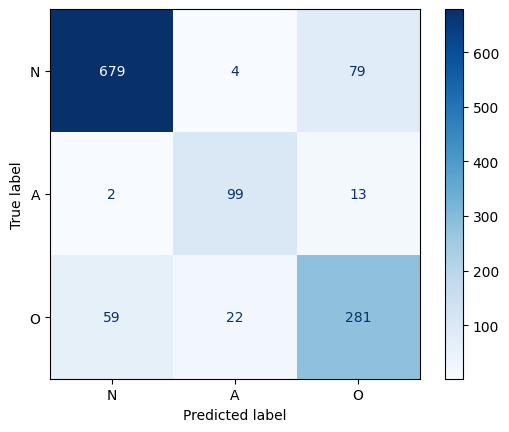

In [9]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# # auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [10]:
wandb.finish()

best_test_accuracy,▁
best_test_auroc,▁
best_test_f1,▁
best_test_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
last_test_accuracy,▁
last_test_auroc,▁
last_test_f1,▁
last_test_loss,▁
lr,████████████████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁
train_acc,▁▂▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
